# Домашее задание №6

Найдите любой временной ряд, содержащий не менее 100 значений и не менее 5 пропусков (если пропусков в исходном файле нет, можно удалить отдельные случайные значения самостоятельно). Выполните следующие задания:

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

1)	Постройте график, визуализирующий временной ряд. Охарактеризуйте его, присутствуют ли тренд, сезонность или цикл?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/monthly-beer-production-in-austr.csv')
df.head()


,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [ ]:
df.info() # нет пропущенных значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
# удалим 10 значений самостоятельно

random_inds = np.random.choice(df.index, size=10, replace=False)

df.loc[random_inds, 'Monthly beer production'] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  466 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m') # изменим тип данных
df # так как число месяца не указано, везде будет установлено 1-ое число

,Month,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


In [ ]:
df.index = df['Month'] # сделаем индексом
del df['Month']
df

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


Text(0, 0.5, 'Monthly beer production (* 10,000 hl)')

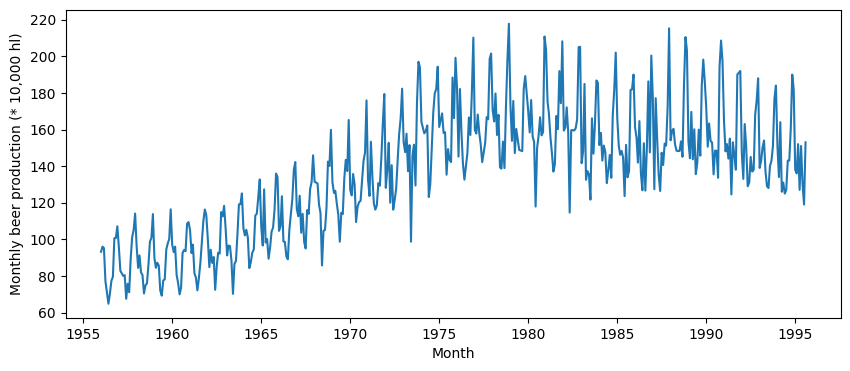

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df['Monthly beer production']) # визуализируем временной ряд
plt.ylabel('Monthly beer production (* 10,000 hl)') # единицы измерения: * 10^5 гектолитров, их можно перевести в литры,
# но для относительного понимания лучше то, что есть

В данных наблюдается тренд (увеличение производства с 1955 до 1980) и сезонность (постоянный период - календарный код), что логично, так как в производстве пива как ингридиенты используются зерна злаковых культур, а урожай зависит от времени года.

2)	Восстановите пропущенные значения. Обоснуйте и опишите метод, который Вы будете использовать для восстановления пропущенных значений.

Будем использовать интерполяцию, так как она наиболее подходит как в большинстве случаев, так и к нашему датасету, учитывая определенный тренд и поведение внутри циклов сезонности. При интерполяции через две известные точки проводится прямая, и так восстанавливается пропущенное значение. Таким образом, у нас не будет странных поведений данных, которые появляются при backfill и forwardfill (чтобы не было горизонтальных прямых между точками) и горбиков (cubicfill). Также у нас всего несколько единичных пропусков (нет длинных пропущенных значений), так что этот метод точно подойдет.

In [ ]:
df1= df.interpolate();
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


### Декомпозиция ряда

Можем сделать декомпозицию и увидеть более ярко наличие тренда (увеличение до 1980, дальше застой) и четкой сезонности.

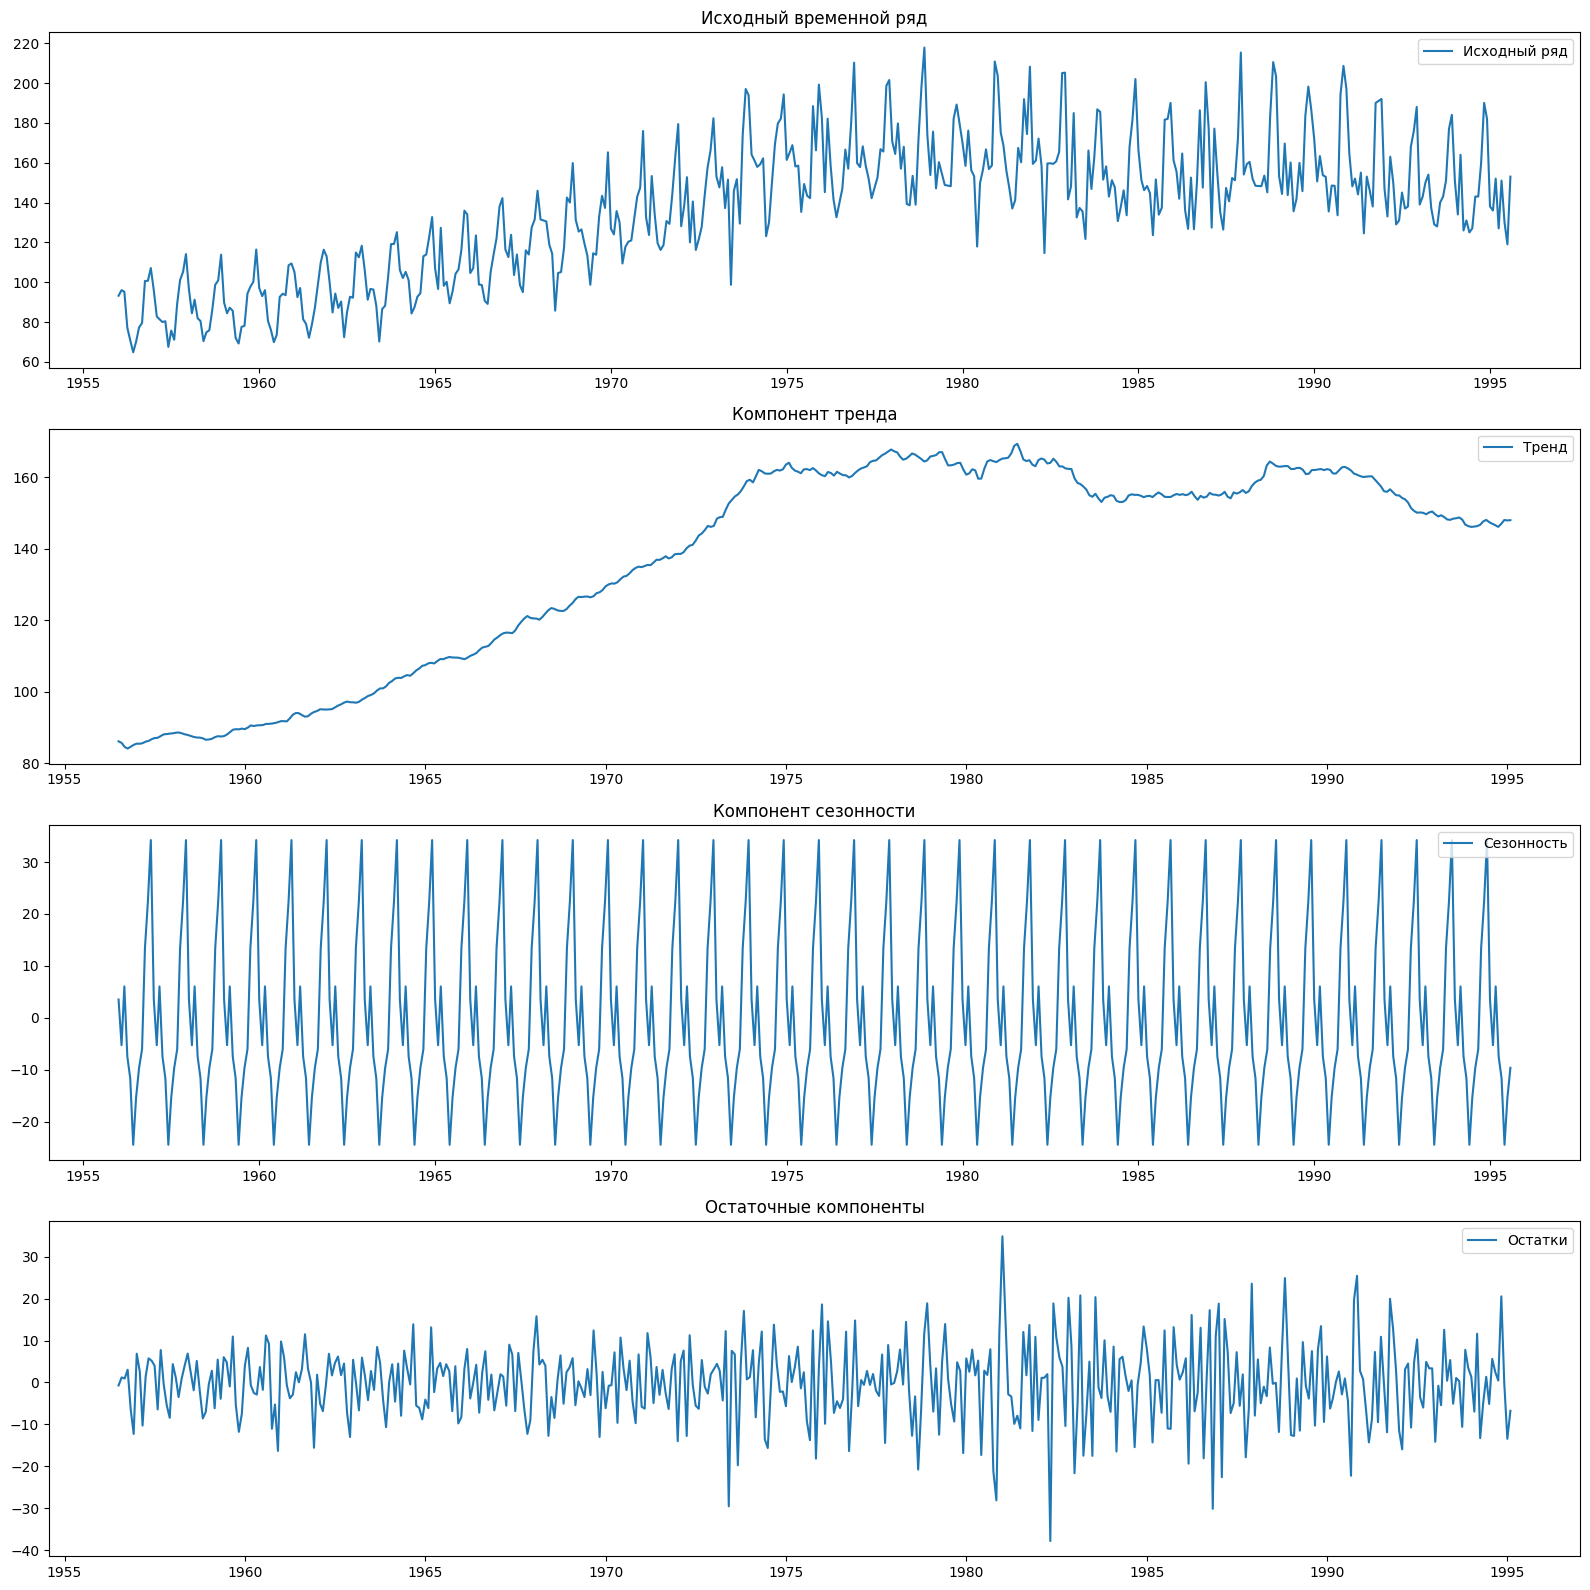

In [ ]:
decomposition = seasonal_decompose(df1, model='additive')

# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 16))

# График исходного временного ряда
plt.subplot(411)
plt.plot(df1.index, df1['Monthly beer production'], label='Исходный ряд')
plt.legend(loc='best')
plt.title('Исходный временной ряд')


# График компонента тренда
plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='best')
plt.title('Компонент тренда')

# График компонента сезонности
plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend(loc='best')
plt.title('Компонент сезонности')

# График остаточных компонентов
plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='best')
plt.title('Остаточные компоненты')

plt.tight_layout()
plt.show()

<Axes: xlabel='Month', ylabel='Monthly beer production'>

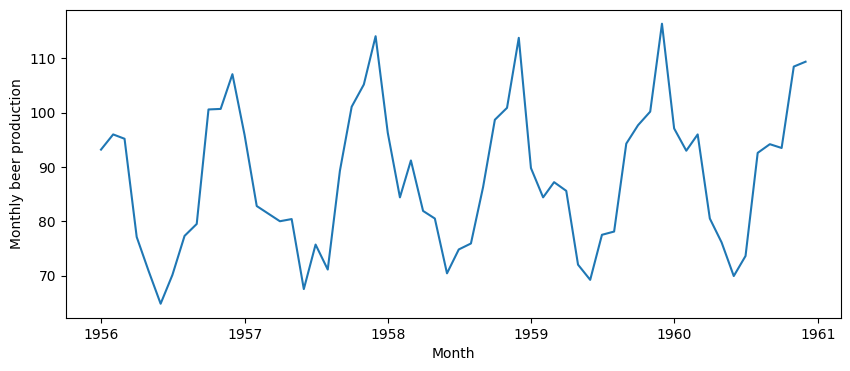

In [ ]:
# заметим по графику, что в начале каждого года наблюдается бугорочек, рассмотрим ближе
plt.figure(figsize=(10, 4))
df2=df.head(60)
sns.lineplot(data=df2, x=df2.index, y=df2['Monthly beer production'])

<Axes: xlabel='Month', ylabel='Monthly beer production'>

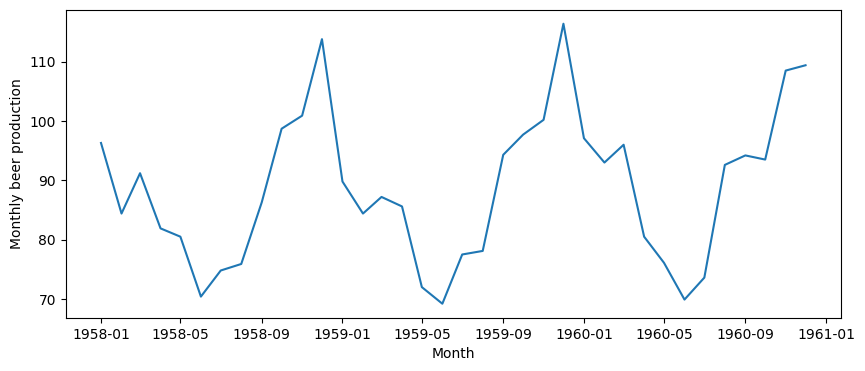

In [ ]:
plt.figure(figsize=(10, 4))
df2=df[24:60] # 1958 - 1960
sns.lineplot(data=df2, x=df2.index, y=df2['Monthly beer production'])

Судя по графику, марте варится побольше пива, чем ожидаемо (по сезонному поведению идет спад). Оказалось, что это связано с историей пивоварения этой страны.

В Австрии даже есть отдельный сорт пива (Marzen), которое традиционно варят в марте.

    3)	Преобразуйте временной ряд к стационарному виду. Обоснуйте и опишите методы, которые Вы использовали. Приведите график и результаты статистических тестов, подтверждающих, что ряд стал стационарным.

In [ ]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность
adft = adfuller(df1)

print('p-value: ', adft[1]) # ожидаемо, так как с началом 1980х года тренда не наблюдается

p-value:  0.19191056728765626


In [ ]:
adft1 = adfuller(df1[:240]) # до 1975 года

print('p-value: ', adft1[1]) # совсем не стационарный

p-value:  0.9988249338805316


Будем дифференцировать (если нужно, несколько раз), чтобы привести стационарному виду.

In [ ]:
df1['Monthly beer production_dif1'] = df1['Monthly beer production'] - df1['Monthly beer production'].shift(1) # один раз дифференцируем ряд
adft = adfuller(df1['Monthly beer production_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1]) # уже стационарный

p-value:  1.3784146460753456e-05


In [ ]:
df1['Monthly beer production_dif2'] = df1['Monthly beer production'] - df1['Monthly beer production'].shift(2) #два раза дифференцируем ряд
adft = adfuller(df1['Monthly beer production_dif2'].dropna(),autolag="AIC")
print('p-value: ', adft[1]) # p-value даже больше, но все равно стационарный

p-value:  0.0006494703883092571


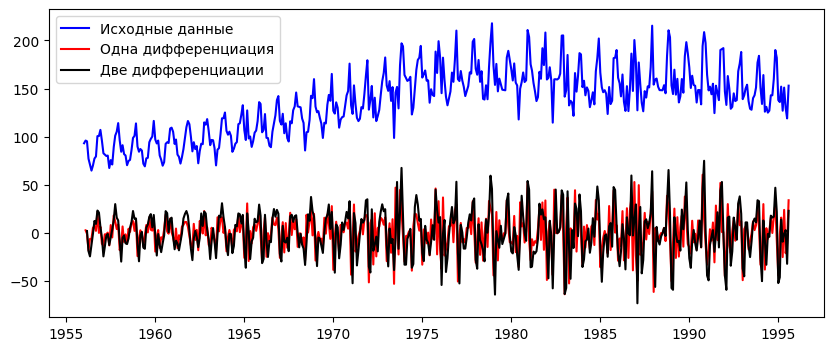

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df1['Monthly beer production'], color="blue",label="Исходные данные")
plt.plot(df1['Monthly beer production_dif1'], color="red", label="Одна дифференциация")
plt.plot(df1['Monthly beer production_dif2'], color="black", label = "Две дифференциации")
plt.legend(loc="best") # один и два раза дифференцируемые ряды практически совпадают

In [ ]:
df1

,Monthly beer production,Monthly beer production_dif1,Monthly beer production_dif2
Month,,,
1956-01-01,93.2,NaN,NaN
1956-02-01,96.0,2.8,NaN
1956-03-01,95.2,-0.8,2.0
1956-04-01,77.1,-18.1,-18.9
1956-05-01,70.9,-6.2,-24.3
...,...,...,...
1995-04-01,127.0,-25.0,-9.0
1995-05-01,151.0,24.0,-1.0
1995-06-01,130.0,-21.0,3.0


4)	Постройте и опишите коррелограммы (графики автокорреляционной функции и частной автокорреляционной функции) для временного ряда.

In [ ]:
autocorrelation_lag1 = df1['Monthly beer production'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)
#коэффициент автокорреляции с лагом 1

One Month Lag:  0.8321651622349554


In [ ]:
autocorrelation_lag3 = df1['Monthly beer production'].autocorr(lag=3)#коэффициент автокорреляции с лагом 3
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df1['Monthly beer production'].autocorr(lag=6) #коэффициент автокорреляции с лагом 6
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df1['Monthly beer production'].autocorr(lag=9) #коэффициент автокорреляции с лагом 9
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.6896605550467922
Six Month Lag:  0.5245591780735278
Nine Month Lag:  0.6844495893094533


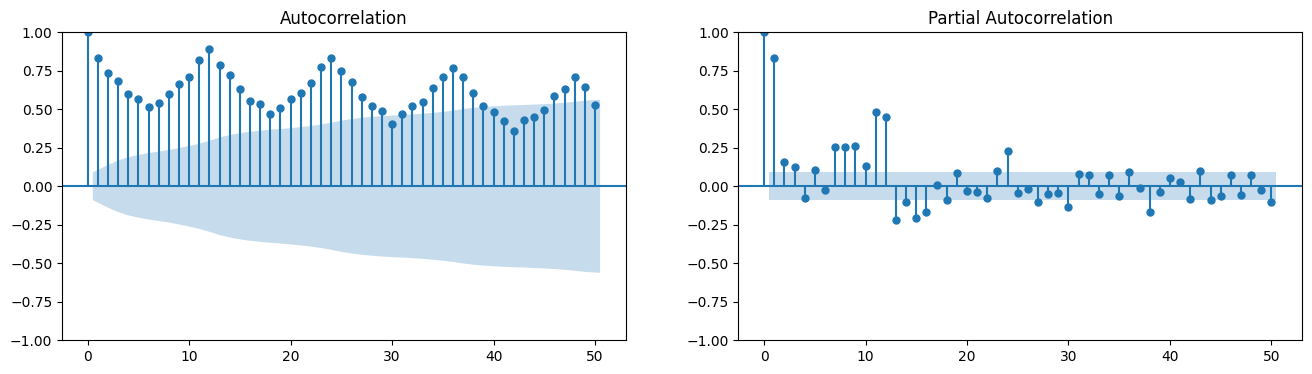

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df1['Monthly beer production'], lags=50, ax=axes[0])
plot_pacf(df1['Monthly beer production'], lags=50, ax=axes[1])
plt.show()


В автокорелляционной функции наглядно отразилось и наличие тренда, и наличие сезонности: на пиках сезонного периода корреляция выше, и самая высокая в начале графика. Видим комбинацию тренда и сезонности.

 5)	Разбейте выборку на обучающую и тестовую (обоснуйте выбор временного интервала для тестовой выборки). На основе обучающей выборки идентифицируйте параметры модели АРПСС (ARIMA). Какие параметры модели p, d и q Вы будете использовать и почему? Оцените качество модели. Насколько хорошо она предсказывает значения тестовой выборки?

In [ ]:
del df1['Monthly beer production_dif1']
del df1['Monthly beer production_dif2']

In [ ]:
df4=df1[df1['Date'] < "1975-01-01"] # сначала посмотрим на график с четким трендом
df4['Date'] = df4.index
train = df4[df4['Date'] < "1970-01-01"] # разбиваем в соотношении 75/25, по первоначальным данным модель должна предугадать тренд и сезонность
del train['Date']
train = train.rename(columns={'Monthly beer production': 'train'})
train

,train
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1969-08-01,113.8
1969-09-01,133.1
1969-10-01,143.4


In [ ]:
test = df4[df4['Date'] >= "1970-01-01"]
del test['Date']
test = test.rename(columns={'Monthly beer production': 'test'})
test

,test
Month,
1970-01-01,126.9
1970-02-01,124.0
1970-03-01,135.7
1970-04-01,130.0
1970-05-01,109.4
1970-06-01,117.8
1970-07-01,120.3
1970-08-01,121.0
1970-09-01,132.3


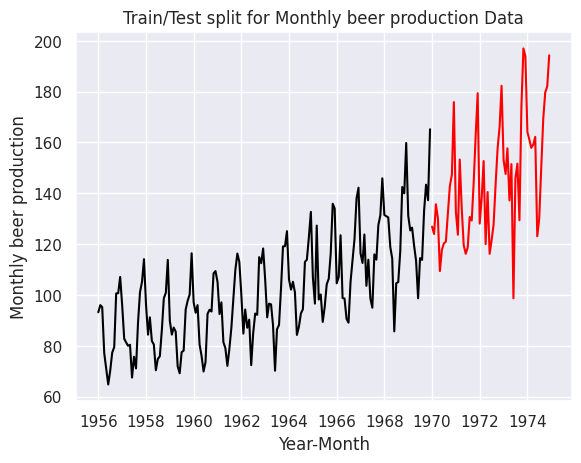

In [ ]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split for Monthly beer production Data")
plt.ylabel("Monthly beer production")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1314.058, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1314.944, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1315.050, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1312.266, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1316.837, Time=1.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 10.919 seconds



Вот такая простая модель, остановились на этих параметрах, так как критерий Акаике самый низкий.

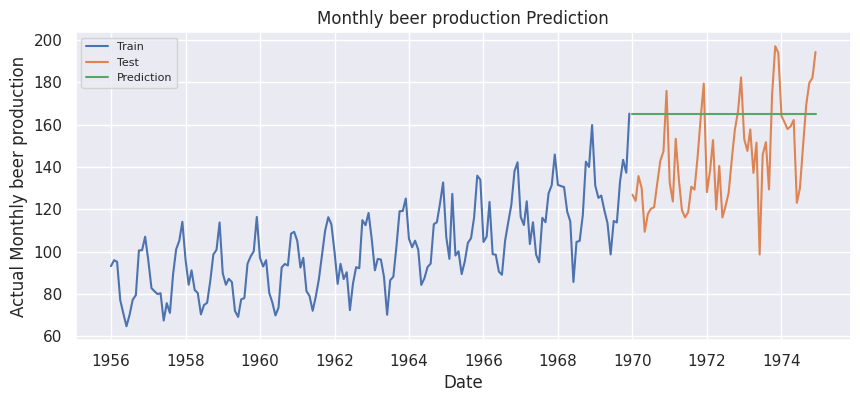

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('Monthly beer production Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Monthly beer production')
plt.legend(loc='upper left', fontsize=8)

Получилась ерунда, сделаем с учетом сезонности:

In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1314.058, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1172.637, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1240.828, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1312.266, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1314.944, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1169.506, Time=0.88 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1156.153, Time=0.52 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1240.167, Time=0.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=3.69 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1205.093, Time=2.96 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1200.117, Time=0.45 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

Тут уже перебираются еще варианты, так как указали параметр сезонности.

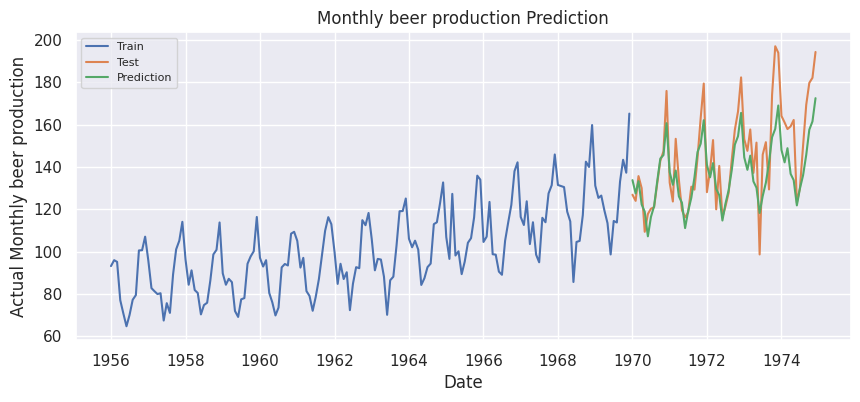

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('Monthly beer production Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Monthly beer production')
plt.legend(loc='upper left', fontsize=8)

Довольно хорошо спрогнозируемо поведение в 1970-1975 годах. Я думаю, что дальшейнее поведение модель скорее всего не предугадает, так как для этого у нее не будет оснований (других данных, влияющих на производство у нас нет). Попробуем посмотреть на это:

In [ ]:
df1['Date'] = df1.index
train = df1[df1['Date'] < "1985-01-01"]
del train['Date']
train = train.rename(columns={'Monthly beer production': 'train'})
train

,train
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1984-08-01,146.1
1984-09-01,133.6
1984-10-01,167.9


In [ ]:
test = df1[df1['Date'] >= "1985-01-01"]
del test['Date']
test = test.rename(columns={'Monthly beer production': 'test'})
test

,test
Month,
1985-01-01,166.5
1985-02-01,151.3
1985-03-01,146.2
1985-04-01,148.3
1985-05-01,144.7
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


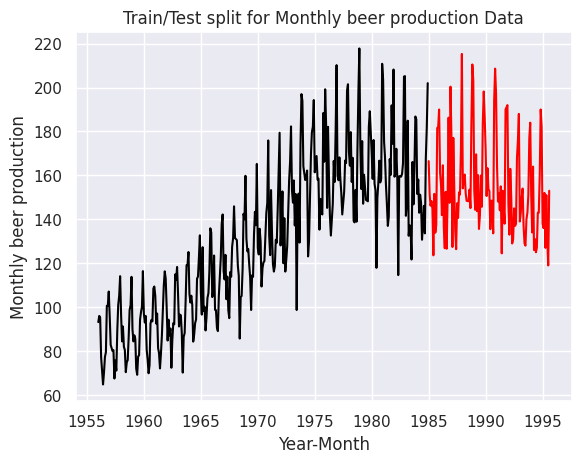

In [ ]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split for Monthly beer production Data")
plt.ylabel("Monthly beer production")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2594.280, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2994.381, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2831.795, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2850.874, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2992.486, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2813.754, Time=3.28 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=7.28 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2670.033, Time=11.66 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2917.264, Time=0.54 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.54 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2660.010, Time=8.90 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.74 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=

То есть 1 раз дифференцируем, взяли для предсказания 5 предыдущих значения и 3 остатка.

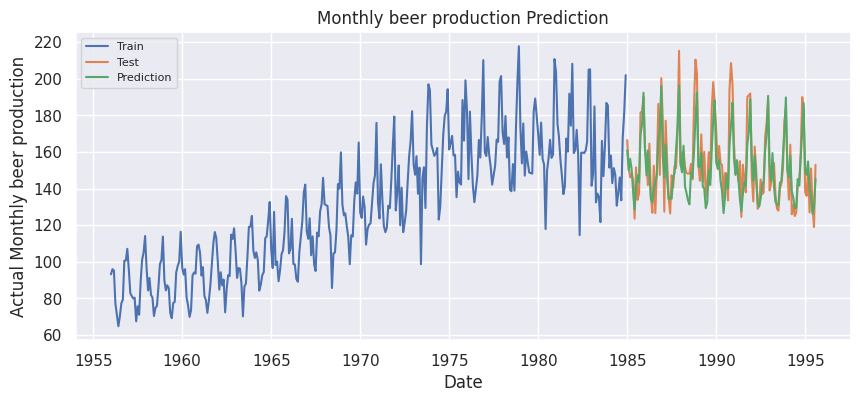

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('Monthly beer production Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Monthly beer production')
plt.legend(loc='upper left', fontsize=8)

Довольно хорошо. Проверим теперь, спрогнозирует ли модель начало застоя...

In [ ]:
df5=df1[df1['Date'] < "1985-01-01"]
df5['Date'] = df5.index
train = df5[df5['Date'] < "1980-01-01"]
del train['Date']
train = train.rename(columns={'Monthly beer production': 'train'})
train

,train
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1979-08-01,148.5
1979-09-01,148.2
1979-10-01,182.2


In [ ]:
test = df5[df5['Date'] >= "1980-01-01"]
del test['Date']
test = test.rename(columns={'Monthly beer production': 'test'})
test

,test
Month,
1980-01-01,170.0
1980-02-01,158.4
1980-03-01,176.1
1980-04-01,156.2
1980-05-01,153.2
1980-06-01,117.9
1980-07-01,149.8
1980-08-01,156.6
1980-09-01,166.7


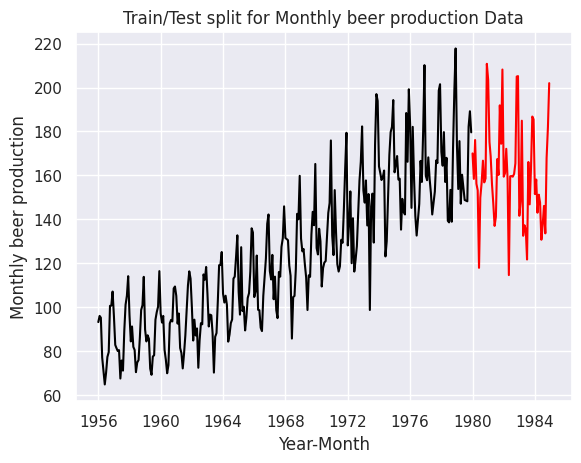

In [ ]:
plt.plot(train, color = "black") #обучающая выборка
plt.plot(test, color = "red") #тестовая выборка
plt.title("Train/Test split for Monthly beer production Data")
plt.ylabel("Monthly beer production")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2427.301, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2235.768, Time=1.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2289.584, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2425.396, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2416.763, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2213.273, Time=2.87 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2168.385, Time=5.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2169.344, Time=0.80 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=2170.838, Time=4.91 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2168.200, Time=5.71 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2266.080, Time=1.44 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2320.785, Time=0.45 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

Тут параметры лучшей модели такие: 1 раз дифференцируем, взяли для предсказания 4 предыдущих значения и 3 остатка.

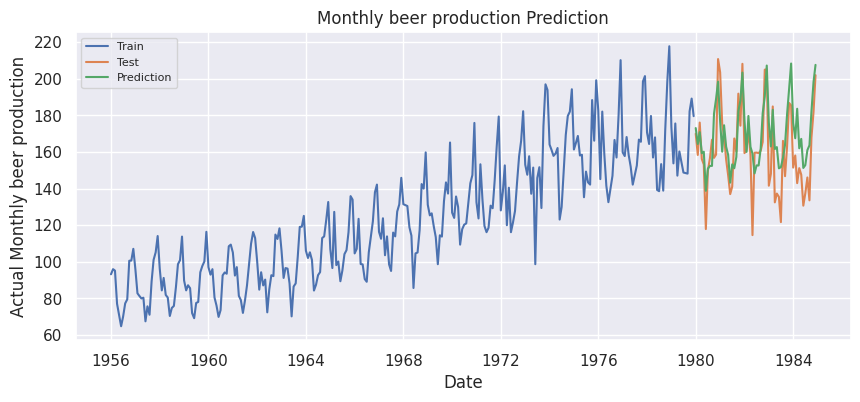

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') #обучающая выборка
plt.plot(test, label='Test') #тестовая выборка
plt.plot(forecast, label='Prediction') #предсказанные значения

plt.title('Monthly beer production Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Monthly beer production')
plt.legend(loc='upper left', fontsize=8)

В принципе неплохо, но со началом снижения производства уже не угадано.

 6)	Используя модель ARIMA, постройте прогноз временного ряда на 30 периодов вперёд. Как Вы считаете, насколько реалистичный получился прогноз?

In [ ]:
df6 = df1
df6['Date'] = df6.index
train = df6
del train['Date']
train = train.rename(columns={'Monthly beer production': 'train'})
train

,train
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


In [ ]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3562.512, Time=5.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4175.238, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3911.247, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3942.073, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4173.258, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3898.267, Time=4.51 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3693.815, Time=4.35 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3562.128, Time=8.17 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3655.337, Time=10.78 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=13.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3561.749, Time=8.59 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3813.754, Time=7.60 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=7.20 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=3567.512, Time=12.34 sec
 ARIMA(3,1,2)(1,0,2)[12] i

NameError: name 'test_data' is not defined

In [ ]:
model.fit(train)
forecast = model.predict(n_periods=360)
#print(forecast)
forecast = pd.DataFrame(forecast)
#forecast = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=360, freq='M'), columns=['Prediction'])
forecast.index = forecast.index.rename('Date')
forecast = forecast.rename(columns={0: 'Prediction'})
forecast

,Prediction
Date,
1995-09-01,130.647085
1995-10-01,162.156608
1995-11-01,184.682876
1995-12-01,177.059135
1996-01-01,146.511207
...,...
2025-04-01,108.926632
2025-05-01,104.543038
2025-06-01,90.503459


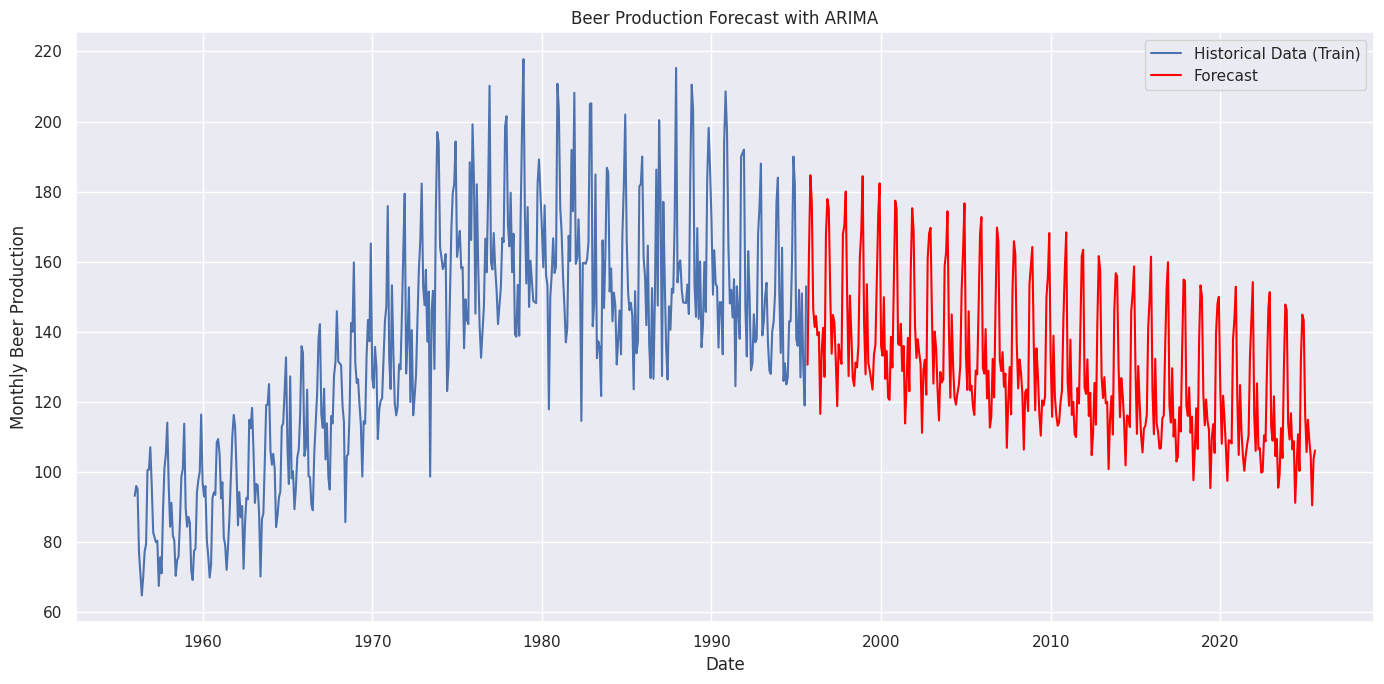

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train, label='Historical Data (Train)')
#plt.plot(test_data['Monthly beer production'], label='Historical Data (Test)') # Добавлено отображение тестовых данных
plt.plot(forecast['Prediction'], label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Monthly Beer Production')
plt.title('Beer Production Forecast with ARIMA')
plt.legend()
plt.grid(True)  # Добавляем сетку для лучшей читаемости
plt.tight_layout() # Улучшаем размещение элементов графика
plt.show()

Модель предсказала продолжение последовательного спада в производстве пива, обучаясь на данных за предыдущие года. Я думаю, что это не совсем правда, а ряд будет в дальнейшем примерно на одном уровне (без тренда), так как производство пива достигло своего предела по возможностям и нуждаемости и будет сохраняться на этом же уровне дальше (исходя из данных в интернете, это действительно так, сильного спада не произошло, но и роста тоже).

Обратите внимание, что все пункты задания должны сопровождаться _выполненным_ фрагментом кода!

# Этот файл нужно сохранить как Notebook (.ipynb) и загрузить в Smart LMS до 13:00 5 февраля.